In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('/content/hour.csv', index_col='dteday')
df

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31,17375,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
2012-12-31,17376,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
2012-12-31,17377,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


In [3]:
df = df.drop(['instant', 'atemp', 'weekday', 'casual', 'registered'], axis=1)
df

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,0,0,1,0.24,0.81,0.0000,16
2011-01-01,1,0,1,1,0,0,1,0.22,0.80,0.0000,40
2011-01-01,1,0,1,2,0,0,1,0.22,0.80,0.0000,32
2011-01-01,1,0,1,3,0,0,1,0.24,0.75,0.0000,13
2011-01-01,1,0,1,4,0,0,1,0.24,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31,1,1,12,19,0,1,2,0.26,0.60,0.1642,119
2012-12-31,1,1,12,20,0,1,2,0.26,0.60,0.1642,89
2012-12-31,1,1,12,21,0,1,1,0.26,0.60,0.1642,90


In [4]:
train_dataset = df.sample(frac=0.8,random_state=0).astype(float)
test_dataset = df.astype(float)

In [5]:
train_labels = train_dataset.pop('cnt').astype(float).values
test_labels = test_dataset.pop('cnt').astype(float).values

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_dataset= scaler.fit_transform(train_dataset)
train_labels = train_labels.reshape(-1,1)
train_labels = scaler.fit_transform(train_labels)

train_dataset

array([[0.33333333, 0.        , 0.36363636, ..., 0.5625    , 0.88      ,
        0.26319502],
       [1.        , 0.        , 0.81818182, ..., 0.4375    , 0.88      ,
        0.        ],
       [1.        , 1.        , 0.81818182, ..., 0.4375    , 0.51      ,
        0.15786999],
       ...,
       [0.        , 0.        , 0.18181818, ..., 0.29166667, 0.87      ,
        0.22804749],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.29      ,
        0.52639003],
       [0.66666667, 0.        , 0.45454545, ..., 0.75      , 0.42      ,
        0.22804749]])

In [7]:
train_dataset = train_dataset[:, np.newaxis]
train_dataset.ndim

3

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
train_dataset.ndim

3

In [10]:
train_dataset.shape

(13903, 1, 10)

In [31]:
from keras.layers import Bidirectional

model = tf.keras.models.Sequential([
  Bidirectional(LSTM(units=64, return_sequences=True,go_backwards=True)),#,dropout=0.5, recurrent_dropout=0.5,activation='relu'
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae', 'mse','accuracy'])

In [33]:
threshold = (train_dataset.max() - train_dataset.min()) * 10/100
threshold

0.10000000000000002

In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold):
      print("\nMAE telah mencapai > 10% dari skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [35]:
history = model.fit(
    train_dataset,
    train_labels, 
    epochs=1000, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=False,
    callbacks=[callbacks]
)

Epoch 1/1000
348/348 [==============================] - 9s 11ms/step - loss: 0.0207 - mae: 0.1428 - mse: 0.0414 - accuracy: 0.0099 - val_loss: 0.0181 - val_mae: 0.1393 - val_mse: 0.0362 - val_accuracy: 0.0086
Epoch 2/1000
348/348 [==============================] - 2s 6ms/step - loss: 0.0162 - mae: 0.1349 - mse: 0.0325 - accuracy: 0.0099 - val_loss: 0.0167 - val_mae: 0.1402 - val_mse: 0.0335 - val_accuracy: 0.0086
Epoch 3/1000
348/348 [==============================] - 2s 6ms/step - loss: 0.0157 - mae: 0.1365 - mse: 0.0314 - accuracy: 0.0099 - val_loss: 0.0165 - val_mae: 0.1411 - val_mse: 0.0329 - val_accuracy: 0.0086
Epoch 4/1000
348/348 [==============================] - 2s 6ms/step - loss: 0.0155 - mae: 0.1369 - mse: 0.0311 - accuracy: 0.0099 - val_loss: 0.0163 - val_mae: 0.1410 - val_mse: 0.0326 - val_accuracy: 0.0086
Epoch 5/1000
348/348 [==============================] - 2s 6ms/step - loss: 0.0154 - mae: 0.1367 - mse: 0.0308 - accuracy: 0.0099 - val_loss: 0.0162 - val_mae: 0.1406 

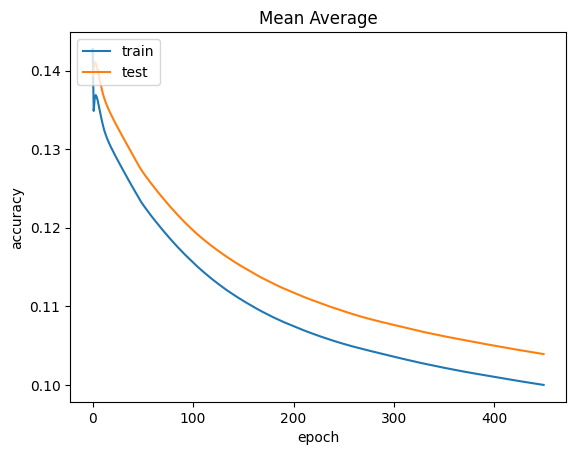

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Average')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

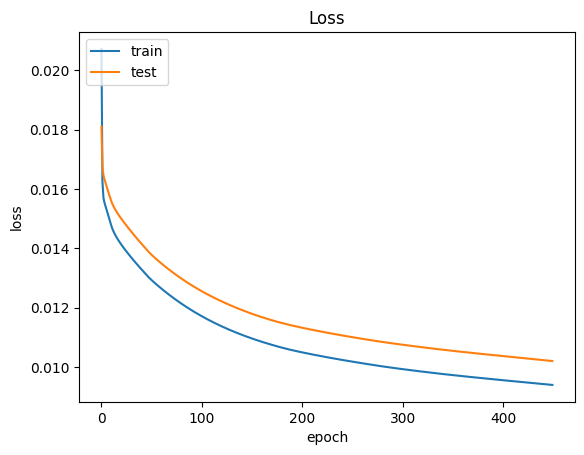

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

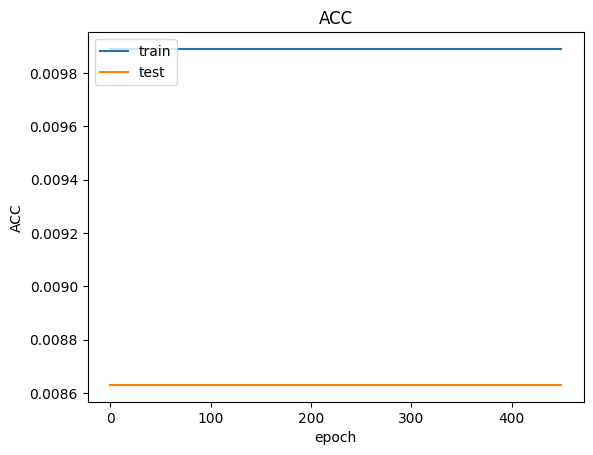

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()